# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.table import Column
from astropy.time import Time
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
import astroalign as aa
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

data/PAL5/PAL5__e1/PAL5__e1_correction_3p6um.fits


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


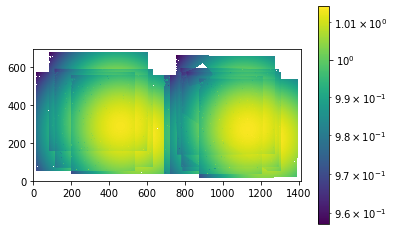

(695, 1413)
1.002447
1.0031966


In [4]:
#pd.read_table('data/PAL5/PAL5__e1/FIF_I1.tbl', comment='#', delim_whitespace=True)
#pd.read_table('data/PAL5/PAL5__e1/FIF_I2.tbl', comment='#', delim_whitespace=True)
#pd.read_table('data/PAL5/PAL5__e1/offsets_I1.tbl', comment='#', delim_whitespace=True)
#pd.read_table('data/PAL5/PAL5__e1/offsets_I2.tbl', comment='#', delim_whitespace=True)

corr_file = 'data/PAL5/PAL5__e1/PAL5__e1_correction_3p6um.fits'
with fits.open(corr_file) as hdu_list:        
    print(corr_file)
    data_corr = hdu_list[0].data
    hdr_corr = hdu_list[0].header
plt.imshow(data_corr, cmap='viridis', origin='lower', norm=LogNorm(), interpolation='nearest')
plt.colorbar()
plt.show()
print(data_corr.shape)
#print(hdr_corr)

print(data_corr[28, 1138])
print(data_corr[400][300])

Importing .fits file, extracting the ~ *data* ~, and converting the image to counts:

In [5]:
#image_file = 'example_data/PAL5_3p6um.fits'
image_file = 'data/PAL5/PAL5__e1/PAL5__e1_3p6um.fits'
#image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
image_data = hdu_list[0].data   # could open data here instead of fits.getdata above, more consistent
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
hdu_list.close()

data = image_data * exptime / fluxconv

print(hdr)
w = wcs.WCS(hdr)
print(w)
#w.wcs.print_contents()

pixcrd = np.array([[300, 300], [360, 550], [600, 250]], dtype=np.float64)
world = w.wcs_pix2world(pixcrd, 0)
print(world)
print(type(data))

print(hdr['TOTALBCD'])
print(data.shape)

EXPTIME: 71.3724
FLUXCONV: 0.1257
SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel- floating point                 NAXIS   =                    2 / STANDARD FITS FORMAT                           NAXIS1  =                 1413 /  Axis Length                                   NAXIS2  =                  695 /  Axis Length                                   TELESCOP= 'Spitzer '           / SPITZER Space Telescope                        INSTRUME= 'IRAC    '           / SPITZER Space Telescope instrument ID          CHNLNUM =                    1 / 1 digit instrument channel number              EXPTYPE = 'sci     '           / Exposure Type                                  FOVID   =                   74 / Field of View ID                               FOVNAME = 'IRAC_Center_of_4.5&8.0umArray' / Field of View Name                  PRODTYPE= 'IMAGE   '           / type of this data                              OBSRVR

In [10]:
JD = Time(hdr['DATE_OBS'], format='isot', scale='utc').jd
MJD = Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd
print(JD)
print(MJD)

56422.90976309031
56422.909763090276


Locating the objects in the image using DAOStarFinder, and plotting no. of stars detected vs. sigma curve:

In [4]:
#def detect_sources(data, sigma_level, FWHM):
#    daofind = DAOStarFinder(threshold = sigma_level * std, fwhm=FWHM)
#    sources = daofind(data - median)
#    return sources

Plotting the number of stars detected across a range of sigma values, allowing us to estimate the best sigma level to use:

In [5]:
mean, median, std = sigma_clipped_stats(data, sigma=6.) # don't need mean any more?
median_alt = np.nanmedian(data)  # just testing a different median out (i think sigma clipped is probably better)

#print(median, bkg_median)

In [6]:
#no_detected = []
#sigma_vals = []
#fwhm = 5.

#for i in np.arange(1., 15.5, 0.5):
#    #print(i)
#    daofind = DAOStarFinder(threshold = i * std, fwhm = fwhm)
#    sources = daofind(data - median)
#    #print(len(sources))
    
#    no_detected.append(len(sources))
#    sigma_vals.append(i)

#print(no_detected)
#print(sigma_vals)

In [7]:
#plt.plot(sigma_vals, no_detected)
#plt.xlabel('sigma')
#plt.ylabel('number of sources detected')
#plt.grid(True)

#plt.savefig('images/sigma_curve_fwhm5.png', dpi=100)

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

597


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


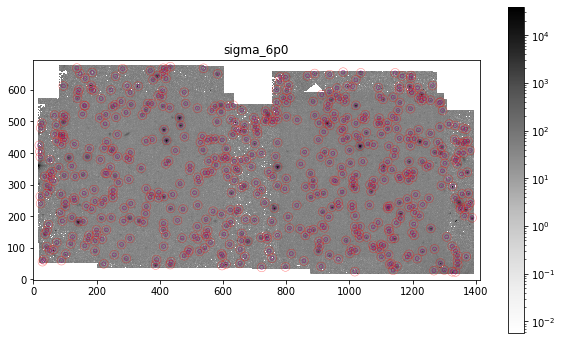

In [8]:
sigma_level = 6.

# 4 sigma seems ideal to me
# fwhm = 3. is roughly the average of many stars tested with imexam (using 1d gaussian fit)
# vicky uses radial fwhm, which varies between 4 - 6 ish; mean is ~4.9, so i'll try 5
# i like the roundness limits at +/- 0.5 personally

#daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5.)
daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5., roundlo = -0.5, roundhi = 0.5)#, sharphi = 0.8)
#sources = daofind(data - median)   # think: do i need to subtract bkg here? or later?
sources = daofind(data)

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)
plt.gcf().set_size_inches(10, 6)

plotname = str(int(sigma_level)) + 'p' + str(int(10 * (sigma_level - int(sigma_level))))
plt.title('sigma_' + plotname)
#plt.savefig('images/sigma_' + plotname, dpi=500)
#plt.savefig('images/yikes_e9.png', dpi=800)

print(len(sources))

In [9]:
#starlist = np.array(sources['xcentroid', 'ycentroid'])
#np.savetxt('outputs/starlist_01.txt', starlist, delimiter=',')

#starread = np.loadtxt('outputs/starlist_01.txt', delimiter=',')
#print(starread)

[[1335.72014301   23.32715629]
 [1017.07204635   24.45613892]
 [1325.4233008    24.0208582 ]
 ...
 [ 538.22025661  667.98722703]
 [ 137.39183303  668.73457781]
 [ 433.18189368  673.11312123]]


Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures are where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli are where annuli overlap)

In [10]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 1335.7201 23.327156            nan            nan
  2  1017.072 24.456139            nan            nan
  3 1325.4233 24.020858            nan            nan
  4 1267.5653 27.531396       9585.387            nan
  5 1138.3723 28.990912      8149.8819            nan
  6  1300.237 29.593042      14476.662            nan
  7 722.22393 37.943258            nan            nan
  8 797.63943 39.455565            nan            nan
  9 910.48561  40.64482      6133.7272      20233.213
 10 1150.0528 41.601753      20206.612      25412.815
...       ...       ...            ...            ...
588  186.0682 654.73342       6578.396      25320.374
589 1036.0708 653.70605            nan            nan
590 980.18034 655.72281            nan            nan
591 370.13387 660.44529      7980.4133      25240.242
592 419.57363 664.80689     

Estimating the local background in the annuli by finding the mean brightness within:

In [11]:
bkg_mean = phot_table['aperture_sum_1'] / annuli.area
#bkg_sum = bkg_mean * apertures.area
#phot_table['bkg_sum'] = bkg_sum
phot_table['bkg_sum'] = bkg_mean * apertures.area
phot_table['residual_sum_mean'] = phot_table['aperture_sum_0'] - phot_table['bkg_sum']
#phot_table['residual_sum_mean'] = final_sum

#for col in final_data.colnames:
#    final_data[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... aperture_sum_1  bkg_sum  residual_sum_mean
       pix       pix    ...                                           
--- --------- --------- ... -------------- --------- -----------------
  1 1335.7201 23.327156 ...            nan       nan               nan
  2  1017.072 24.456139 ...            nan       nan               nan
  3 1325.4233 24.020858 ...            nan       nan               nan
  4 1267.5653 27.531396 ...            nan       nan               nan
  5 1138.3723 28.990912 ...            nan       nan               nan
  6  1300.237 29.593042 ...            nan       nan               nan
  7 722.22393 37.943258 ...            nan       nan               nan
  8 797.63943 39.455565 ...            nan       nan               nan
  9 910.48561  40.64482 ...      20233.213  4552.473         1581.2542
 10 1150.0528 41.601753 ...      25412.815 5717.8835         14488.728
...       ...       ... ...            ...       ...               ...
588  1

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [28]:
annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]   # create 1d array of pixel values in the mask
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
#phot = aperture_photometry(data, apertures)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = phot_table['aperture_sum_0'] - phot_table['aper_bkg']

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

WARNING

 id  xcenter   ycenter  ... apparent_mag_mean apparent_mag_median
       pix       pix    ...                                      
--- --------- --------- ... ----------------- -------------------
  1 1335.7201 23.327156 ...               nan                 nan
  2  1017.072 24.456139 ...               nan                 nan
  3 1325.4233 24.020858 ...               nan                 nan
  4 1267.5653 27.531396 ...               nan            16.71333
  5 1138.3723 28.990912 ...               nan           16.373046
  6  1300.237 29.593042 ...               nan           16.016359
  7 722.22393 37.943258 ...               nan                 nan
  8 797.63943 39.455565 ...               nan                 nan
  9 910.48561  40.64482 ...         17.084938           17.036153
 10 1150.0528 41.601753 ...         14.679867           14.661739
...       ...       ... ...               ...                 ...
588  186.0682 654.73342 ...         17.719618           17.694233
589 1036.0

: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]


Trying to calculate the apparent magnitudes of each star:

I think the negative 'aper_sum_bkgsub's happen in crowded areas where the annulus counts another star as the background, so the bkg value is larger than the aperture sum, or where the star itself is so dim the bkg est is higher, or a mix of both. Does this mean I need a higher threshold or fwhm to rule out the dim boyos? Who knows

In [35]:
#flux_zeromag = 280.9         # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1; for 4.5, = 179.7 +/- 2.6
flux_zeromag = 179.7
#zmag = 18.80                 # given in/calculated using IRAC handbook, section 4.8; for 4.5um, = 18.3177 = 18.32
zmag = 18.32
#aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7; channel 2 = 1.120
aperture_correction = 1.120
conv = fluxconv / exptime
negative_sums = []

print(np.floor(phot_table['xcenter'][4].value))
print(int(phot_table['xcenter'][4].value))
print(np.floor(phot_table['ycenter'][4].value))
print(int(phot_table['ycenter'][4].value))
print(data_corr[int(phot_table['ycenter'][4].value)][int(phot_table['xcenter'][4].value)])  # remember: order is y, x

phot_table['apparent_mag_mean'] = float('NaN')
phot_table['apparent_mag_median'] = float('NaN')   # idk why i have to fill the new column with NaNs first but hey ho it works
phot_table['apparent_mag_median_corr'] = float('NaN')

for i in range(len(phot_table)):
    location_corr = data_corr[int(phot_table['ycenter'][i].value)][int(phot_table['xcenter'][i].value)]
    if phot_table['residual_sum_mean'][i] >= 0:
        phot_table['apparent_mag_mean'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['residual_sum_mean'][i])
    if phot_table['aper_sum_bkgsub'][i] >= 0:
        phot_table['apparent_mag_median'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['aper_sum_bkgsub'][i])
        phot_table['apparent_mag_median_corr'][i] = zmag - 2.5 * math.log10(location_corr * aperture_correction * conv * phot_table['aper_sum_bkgsub'][i])
    else:
        negative_sums.append(phot_table['id'][i])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)
#print(negative_sums)

print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_mean'])))
print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_median'])))



1138.0
1138
28.0
28
1.002447
 id  xcenter   ycenter  ...  loc_corr  apparent_mag_median_corr
       pix       pix    ...                                    
--- --------- --------- ... ---------- ------------------------
  1 1335.7201 23.327156 ...  1.0013357                      nan
  2  1017.072 24.456139 ... 0.99182606                      nan
  3 1325.4233 24.020858 ...  1.0019559                      nan
  4 1267.5653 27.531396 ...  1.0044675                16.708491
  5 1138.3723 28.990912 ...   1.002447                16.370392
  6  1300.237 29.593042 ...  1.0037128                16.012336
  7 722.22393 37.943258 ...  0.9754833                      nan
  8 797.63943 39.455565 ... 0.98723608                      nan
  9 910.48561  40.64482 ... 0.98860693                17.048594
 10 1150.0528 41.601753 ...  1.0029764                14.658513
...       ...       ... ...        ...                      ...
588  186.0682 654.73342 ... 0.97665566                 17.71988
589 1036.07

In [36]:
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,bkg_sum,residual_sum_mean,annulus_median,aper_bkg,aper_sum_bkgsub,apparent_mag_mean,apparent_mag_median,loc_corr,apparent_mag_median_corr
,pix,pix,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1335.7201,23.327156,nan,nan,nan,nan,90.919182,10282.717,nan,nan,nan,1.0013357,nan
2,1017.072,24.456139,nan,nan,nan,nan,42.764639,4836.5667,nan,nan,nan,0.99182606,nan
3,1325.4233,24.020858,nan,nan,nan,nan,89.49353,10121.48,nan,nan,nan,1.0019559,nan
4,1267.5653,27.531396,9585.387,nan,nan,nan,65.065842,7358.7733,2226.6137,nan,16.71333,1.0044675,16.708491
5,1138.3723,28.990912,8149.8819,nan,nan,nan,45.126446,5103.6808,3046.2011,nan,16.373046,1.002447,16.370392
6,1300.237,29.593042,14476.662,nan,nan,nan,90.592384,10245.757,4230.9048,nan,16.016359,1.0037128,16.012336
7,722.22393,37.943258,nan,nan,nan,nan,39.160315,4428.9272,nan,nan,nan,0.9754833,nan
8,797.63943,39.455565,nan,nan,nan,nan,39.490507,4466.2711,nan,nan,nan,0.98723608,nan


## Writing to file:

In [39]:
#phot_table['id', 'xcenter', 'ycenter', 'apparent_mag_median'].write('outputs/e1_4p5.txt', format='csv', overwrite=True)

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
         2.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,  1.,  3.,  2.,  1.,  3.,
         2.,  0.,  1.,  0.,  2.,  3.,  0.,  1.,  4.,  0.,  0.,  1.,  3.,
         3.,  2.,  4.,  0.,  2.,  4.,  2.,  1.,  1.,  3.,  2.,  9.,  4.,
         3.,  4.,  5.,  4.,  3.,  4.,  5.,  7.,  6.,  2.,  8.,  1.,  8.,
         9.,  7.,  4.,  8.,  6.,  6.,  6.,  7.,  6.,  7., 10., 14., 11.,
        16.,  7., 12., 12., 10.,  7.,  8., 11., 10.,  8.,  8.,  5., 10.,
        10.,  9.,  8.,  7.,  4.,  2.,  1.,  9.,  7.,  6.,  8.,  1.,  0.,
         6.,  5.,  3.,  2.,  4.,  2.,  1.,  4.,  0.,  1.,  1.,  0.,  3.,
         1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

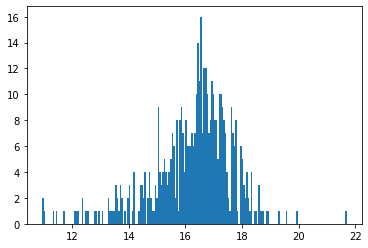

In [40]:
plt.hist(phot_table['apparent_mag_mean'], bins=200)
#plt.hist(phot_table['apparent_mag_median'], bins=200)

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


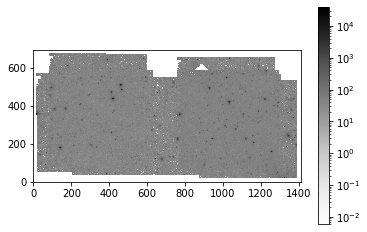

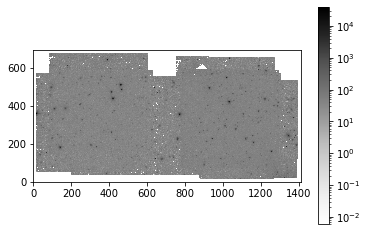

597 594


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


 id  xcenter   ycenter  apparent_mag_comp
       pix       pix                     
--- --------- --------- -----------------
  1  1335.874 23.001977               nan
  2 1325.5626  23.66314               nan
  3 1267.7441 27.173042         16.620724
  4 1138.5661 28.606267          16.35752
  5 1300.4332 29.231301         15.974934
  6   797.788 38.844313               nan
  7 910.65034 40.078595         17.020956
  8 1150.1934  41.17284         14.661304
  9  596.9203 43.066308               nan
 10 386.88452 44.633777         13.608715
...       ...       ...               ...
585 410.78727 650.60498         19.946163
586 889.85879 650.91624         15.607762
587 980.18831 655.87076               nan
588 370.03351 659.64085         16.649139
589 419.44732 664.05577         16.159034
590  282.2265 665.66802         17.167326
591 410.47653  667.3616         15.546009
592 538.13867  667.2605               nan
593 137.23726 667.87497               nan
594 433.06979 672.36633           

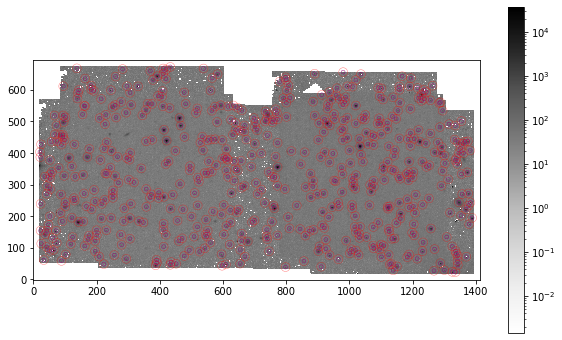

In [41]:
file_comp = 'data/PAL5/PAL5__e2/PAL5__e2_3p6um.fits'

with fits.open(file_comp) as hdu_list:
    image_data_comp = hdu_list[0].data
    hdr_comp = hdu_list[0].header
    data_comp = image_data_comp * hdr_comp['EXPTIME'] / hdr_comp['FLUXCONV']
#print(data[400, 400], np.array(data)[400, 400])
#print(data_to_pd)
#print(np.array(image_data))
#print(data[400, 400], data_comp[400, 400])

data_aligned, footprint = aa.register(np.array(data), np.array(data_comp))

plt.imshow(data_aligned, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
plt.show()
plt.close()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
plt.show()
plt.close()

_, median_comp, std_comp = sigma_clipped_stats(data_aligned, sigma=6.)

daofind_comp = DAOStarFinder(threshold = sigma_level * std_comp, fwhm = 5., roundlo = -0.5, roundhi = 0.5)
#sources_comp = daofind_comp(data_aligned - median_comp)
sources_comp = daofind_comp(data_aligned)

pos_comp = np.transpose((sources_comp['xcentroid'], sources_comp['ycentroid']))
apertures = CircularAperture(pos_comp, r=6.)
annuli = CircularAnnulus(pos_comp, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data_aligned, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)
plt.gcf().set_size_inches(10, 6)

print(len(sources), len(sources_comp))

phot_comp = aperture_photometry(data_aligned, all_apers)

annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data_aligned)
    annulus_data_1d = annulus_data[mask.data > 0]   # create 1d array of pixel values in the mask
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
#phot = aperture_photometry(data, apertures)
phot_comp['annulus_median'] = bkg_median
phot_comp['aper_bkg'] = bkg_median * apertures.area
phot_comp['aper_sum_bkgsub'] = phot_comp['aperture_sum_0'] - phot_comp['aper_bkg']

phot_comp['apparent_mag_comp'] = float('NaN')

for i in range(len(phot_comp)):
    if phot_comp['aper_sum_bkgsub'][i] >= 0:
        phot_comp['apparent_mag_comp'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_comp['aper_sum_bkgsub'][i])
        
for col in phot_comp.colnames:
    phot_comp[col].info.format = '%.8g'
print(phot_comp['id', 'xcenter', 'ycenter', 'apparent_mag_comp'])
print(phot_table['id', 'xcenter', 'ycenter', 'apparent_mag_median'])

In [42]:
#filename_ap = 'outputs/apphot_test01.txt'
#filename_psf = 'outputs/psf_test01.txt'
#file_ap = np.genfromtxt(filename_ap, skip_header=1, delimiter=',', dtype=None, unpack=True, encoding=None)
#file_psf = np.genfromtxt(filename_psf, skip_header=1, delimiter=',', dtype=None, unpack=True, encoding=None)

In [43]:
#print(file_ap)
#print(np.shape(file_ap))

#mag_ap = []
#mag_ap = file_ap[:,3]
#print(mag_ap)

#testy = np.insert(file_ap, )

In [44]:
#t = Table.write(phot_table, 'outputs/table_test_ap.', delimiter=',', format='ascii')